# Titanic model

This notebook covers the steps for building a simple machine learning model that predicts whether a given passenger is expected to the survive the titanic disaster. This involves some preprocessing steps for extracting features and training a random forest model on the engineered dataset.

### Steps Covered

1. Loading the data
2. Visualizing some variables
3. Creating features
4. Training the model
5. Evaluating the model
6. Producing predictions

## Loading the data

We can load the dataset into a dataframe by calling `pd.read_csv`. Note that we split our dataset into a train and test set, so that we can do some exploration on our training set and later guage the accuracy of our model on the test set. 

In [92]:
%matplotlib inline
import pandas as pd

# Read train/eval datasets.
data = pd.read_csv('../data/train.csv')

# Split data into train/test set.
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

data_train.sample(3, random_state=42)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
373,374,0,1,"Ringhini, Mr. Sante",male,22.0,0,0,PC 17760,135.6333,NaN,C
848,849,0,2,"Harper, Rev. John",male,28.0,0,1,248727,33.0000,NaN,S
593,594,0,3,"Bourke, Miss. Mary",female,NaN,0,2,364848,7.7500,NaN,Q


## Visualizing some variables

Visualizing data is crucial for recognizing underlying patterns to exploit in the model. 

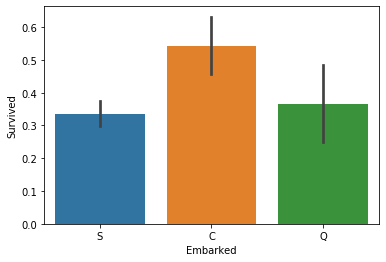

In [136]:
sns.barplot(x="Embarked", y="Survived", data=data_train);

From this plot, there doesn't seem to be a strong relationship between Survival and where a passenger embarked. 

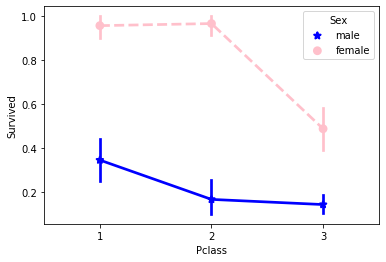

In [137]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=data_train,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"]);

Here we see a relatively strong relationship between male/female and passenger class with Survival, indicating that these might be useful features for training a model.

## Creating some features

From the (limited) exploration above, it looks as if passenger class (Pclass) and gender (Sex) seem to be strong predictors of survival. As such, we can try to create a simple model based on these two features. 

To feed these features into a scikit-learn model, we need to perform the following transformations:

1. Select the two features from the dataset (dropping other features).
2. Fill any missing values in these features (sklearn models generally don't like missing values)
3. Encode Sex as a numeric value using one-hot encoding (Sex is categorical, but sklearn models require numeric feature values)

After this, we can feed the resulting (numeric) feature values into an sklearn model.

In [95]:
def extract_features(data):
    # Select our features.
    X = data[["Pclass", "Sex"]]
    
    # Impute missing values with most common value.
    X = X.fillna(X.mode())

    # Encode categoricals as numeric values using one-hot encoding.
    X = pd.get_dummies(X, drop_first=True)
        
    return X


X_train = extract_features(data_train)
y_train = data_train["Survived"]

X_train.head()

,Pclass,Sex_male
331,1,1
733,2,1
382,3,1
704,3,1
813,3,0


## Training a model

To train our model, we can feed the prepared dataset into an sklearn model. In this case, we decide to use a RandomForest-based model, as this is a flexible, non-linear model that is relatively robust against overfitting. 

In [97]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(n_estimators=100)
estimator.fit(X_train, y=y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

For now, we don't spend any time optimizing any hyper parameters for the model, although this may be interesting to explore in future work.

## Evaluating our model

To determine how well our model performs, we can plot a confusion matrix of our predictions for our test set (which we created earlier):

In [133]:
from sklearn.metrics import confusion_matrix

def _confusion_matrix(y_true, y_pred, **kwargs):
    """Simple wrapper that adds labels to the standard sklearn confusion matrix."""
    
    mat = pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=y_pred, **kwargs))
    mat.columns.name = "predicted"
    mat.index.name = "actual"
    
    return mat


X_test = extract_features(data_test)
y_test = data_test["Survived"]

y_pred = estimator.predict(X_test)

_confusion_matrix(y_true=y_test, y_pred=y_pred)

predicted,0,1
actual,,
0,101,4
1,38,36


Here we see that our model is quite good at predicting which passengers did not survive, but has some trouble identifying which people survived the titanic. We can also summarize the performance of our model using an accuracy score:

In [105]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true=y_test, y_pred=y_pred)

0.7653631284916201

Of course, this score is only a single estimate and does not give us an idea of how well our model might perform for different splits of our dataset. To get a better idea of performance accross the dataset, we can use cross-validation (which splits our data into multiple train/test sets and evaluates our model on these sets) to get a better idea of the variability in our predictions:

In [114]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, KFold

X_all = extract_features(data)
y_all = data["Survived"]

scorer = make_scorer(accuracy_score)
folds = KFold(5, random_state=42)

cross_val_score(estimator, X=X_all, y=y_all, scoring=scorer, cv=folds).mean()

0.7732785135898562

This shows that our accuracy on our test set is not very different from the score we obtained from the test set, indicating that this model achieves an overall accuracy of ~0.77.

## Producing predictions

Finally, we can load our evaluation dataset (which was provided to us without labels) and produce predictions for this dataset:

In [110]:
data_eval = pd.read_csv("../data/test.csv")

X_eval = extract_features(data_eval)
X_eval.head()

,Pclass,Sex_male
0,3,1
1,3,0
2,2,1
3,3,1
4,3,0


In [111]:
estimator = RandomForestClassifier(n_estimators=100)
estimator = estimator.fit(X_all, y=y_all)

estimator.predict(X_eval)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,